# Glaciers explorer using Datashader

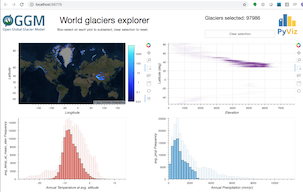

This notebook provides an annotated [HoloViews](https://holoviews.org)+[Panel](https://panel.pyviz.org) implementation of a [dashboard originally developed in Plotly+Dash](https://github.com/OGGM/OGGM-Dash/blob/master/apps/explore/app.py) for viewing data about the Earth's glaciers from the [Open Global Glacier Model](https://oggm.org).  To run it, first:

    conda install -c pyviz pandas=0.24 param=1.9.0 panel=0.5.1 holoviews=1.12.2 geoviews=1.6.2 datashader=0.7.0

Next, save the [data file](https://cluster.klima.uni-bremen.de/~fmaussion/misc/oggm_glacier_explorer.csv) as `data/oggm_glacier_explorer.csv` (and gzip it if desired).

The dashboard can then be used here as a cell in the Jupyter notebook, or you can run it as a separate server using:

    bokeh serve glaciers.ipynb --show
    
This notebook is essentially the same as [Glaciers.ipynb](https://anaconda.org/jbednar/glaciers) but uses unaggregated data that is practical only with [Datashader](http://datashader.org).

In [ ]:
import os, numpy as np, pandas as pd, cartopy.crs as ccrs, bokeh
import holoviews as hv, geoviews as gv, datashader as ds

from colorcet import bmy
from holoviews.util import Dynamic
from holoviews.operation.datashader import rasterize, datashade

hv.extension('bokeh', width=100)

## Load the data

In [ ]:
df = pd.read_csv('data/oggm_glacier_explorer.csv')
df['latdeg'] = df.cenlat

df.tail()

## Plot the data

As you can see in the dataframe, there are a lot of things that could be plotted about this dataset, but following the [previous version](https://github.com/OGGM/OGGM-Dash/blob/master/apps/explore/app.py) let's focus on the lat/lon location, elevation, temperature, and precipitation.  We'll use tools from [PyViz](http://pyviz.org), starting with [HoloViews](https://holoviews.org) as an easy way to build interactive [Bokeh](http://bokeh.pydata.org) plots. So that we can use the full glacier database with good performance, we'll have [Datashader](http://datashader.org) pre-render some of the plots as images before they reach the browser.

To start, let's declare a HoloViews object that captures English-text descriptions of the various columns in the dataframe, in a way that subsequent plots can all inherit without having to repeat that information:

In [ ]:
data = gv.Points(df, [('cenlon', 'Longitude'), ('cenlat', 'Latitude')],
                     [('avg_prcp', 'Annual Precipitation (mm/yr)'),
                      ('area_km2', 'Area'), ('latdeg', 'Latitude (deg)'),
                      ('avg_temp_at_mean_elev', 'Annual Temperature at avg. altitude'), 
                      ('mean_elev', 'Elevation')])
total_area = df.area_km2.sum()
print(data, len(data), total_area)

Here we've declared that `cenlon` and `cenlat` (the lat,lon location of the center of the glacier) are the ["key dimensions"](http://holoviews.org/getting_started/Tabular_Datasets.html#Tabular) (independent values that specify which glacier this is), and the rest are "value dimensions" (various dependent values characterizing that particular sample).

To make it faster to work with this data in plots, let's project all the lat,lon values into a coordinate system that can be displayed on top of tile-based online maps.  We'll still need the original latitudes in degrees for some purposes, so we saved those above in a column `latdeg`.

In [ ]:
data = gv.Dataset(gv.operation.project_points(data))

Next, let's define various options that will control the appearance of our plots:

In [ ]:
geo_kw    = dict(aggregator=ds.sum('area_km2'), x_sampling=1000, y_sampling=1000)
elev_kw   = dict(cmap='#7d3c98')
temp_kw   = dict(num_bins=50, adjoin=False, normed=False, bin_range=data.range('avg_temp_at_mean_elev'))
prcp_kw   = dict(num_bins=50, adjoin=False, normed=False, bin_range=data.range('avg_prcp'))

size_opts = dict(min_height=400, min_width=600, responsive=True)
geo_opts  = dict(size_opts, cmap=bmy, global_extent=False, logz=True, colorbar=True)
elev_opts = dict(size_opts, show_grid=True)
temp_opts = dict(size_opts, fill_color='#f1948a', default_tools=[], toolbar=None, alpha=1.0)
prcp_opts = dict(size_opts, fill_color='#85c1e9', default_tools=[], toolbar=None, alpha=1.0)

Using these options with HoloViews and GeoViews, we can plot various combinations of the variables of interest:

In [ ]:
geo_bg = gv.tile_sources.EsriImagery.options(alpha=0.6, bgcolor="black")
geopoints = data.to(gv.Points, ['cenlon', 'cenlat'], ['area_km2'], []).options(**geo_opts).redim.range(area_km2=(0, 3000))

(geo_bg*rasterize(geopoints, **geo_kw).options(**geo_opts) + 
 datashade(data.to(hv.Scatter, 'mean_elev','latdeg', []), **elev_kw).options(**elev_opts) + 
 data.hist('avg_temp_at_mean_elev', **temp_kw).options(**temp_opts) +
 data.hist('avg_prcp',              **prcp_kw).options(**prcp_opts)).cols(2)

In the top left we've overlaid the location centers on a web-based map of the Earth, separately making a scatterplot of those same datapoints in the top right with elevation versus latitude. The bottom rows show histograms of temperature and precipitation for the whole set of glaciers. Of course, these are just some of the many plots that could be constructed from this data; see [holoviews.org](http://holoviews.org) for inspiration.

## Define plotting functions

The above plots are useful for understanding the properties of all glaciers worldwide, but what's more interesting is to consider how some particular subset of the glaciers relates to the rest.  To explore this, let's capture the above commands into some functions that will accept a dataset and return viewable plots for that particular data.  That way we can plot selected subsets of the data and compare them to the plots of the full dataset.

In [ ]:
def geo(data):   return gv.Points(data, crs=ccrs.GOOGLE_MERCATOR).options(alpha=1)
def elev(data):  return data.to(hv.Scatter, 'mean_elev', 'latdeg', [])
def temp(data):  return data.hist('avg_temp_at_mean_elev', **temp_kw).options(**temp_opts)
def prcp(data):  return data.hist('avg_prcp',              **prcp_kw).options(**prcp_opts)
def count(data): return hv.Div('<p style="font-size:20px">Glaciers selected: {}'.format(len(data)) + "<br>" +
                               'Area: {:.0f} km² ({:.1f}%)</font>'.format(np.sum(data['area_km2']), np.sum(data['area_km2']) / total_area * 100)).options(height=40)

If called with the full dataset:

    (geo_bg*rasterize(geo(data), **geo_kw).options(**geo_opts) + datashade(elev(data), **elev_kw).options(**elev_opts) + temp(data) + prcp(data)).cols(2)

these functions will return static plots just like those above. Let's capture that output as a set of low-opacity (`alpha<0.5`) plots to use as a background on which to show selected subsets of the data:

In [ ]:
static_geo  = rasterize(geo(data),   **geo_kw).options(alpha=0.1, tools=['hover', 'box_select'], active_tools=['box_select'], **geo_opts)
static_elev = datashade(elev(data), **elev_kw).options(alpha=0.1, tools=[         'box_select'], active_tools=['box_select'], **elev_opts)
static_temp = temp(data).options(alpha=0.1)
static_prcp = prcp(data).options(alpha=0.1)

Here we defined some Bokeh tools like `hover` and `box_select` that you'll see below. Meanwhile, we could plot these on their own if we wished:

    (geo_bg*static_geo + static_elev + static_temp + static_prcp).cols(2)

## Selections

Now that we have some static plots for the background and some functions to create plots dynamically, we can set up selections linked between each of the static plots and determining which data is shown dynamically. We'll be using [HoloViews streams](http://holoviews.org/user_guide/Custom_Interactivity.html), which allow any of a variety of data producers to be linked to any of a variety of data consumers.  First, we'll define functions for selecting by 1D or 2D value range:

In [ ]:
def combine_selections(**kwargs):
    """
    Combines selections on all available plots into a single selection by index.
    """
    if all(not v for v in kwargs.values()):
        return slice(None)
    selection = {}
    for key, bounds in kwargs.items():
        if bounds is None:
            continue
        elif len(bounds) == 2:
            selection[key] = bounds
        else:
            xbound, ybound = key.split('__')
            selection[xbound] = bounds[0], bounds[2]
            selection[ybound] = bounds[1], bounds[3]
    return sorted(set(data.select(**selection).data.index))

def select_data(**kwargs):
    return data.iloc[combine_selections(**kwargs)] if kwargs else data

Here, `select_data` will accept various keyword arguments that specify 2D or 1D bounds with which to filter the data.  A 2D bound uses four values and selects on the values of two columns (here with values in Web Mercator coordinates):

In [ ]:
select_data(cenlon__cenlat=(3000000, 9000000, 5000000, 11000000)).dframe()

Each additional selection will further narrow down the items selected.  Here we further select by a 1D bound on temperature, to select only those with an average temperature below -2 degrees:

In [ ]:
select_data(cenlon__cenlat=(3000000, 9000000, 5000000, 11000000), avg_temp_at_mean_elev=(-5,-2)).dframe()

Separately, we can instantiate some Stream-based selection objects provided by HoloViews that capture user selection/bounds events on each of the static plots:

In [ ]:
from holoviews.streams import Stream, BoundsXY, BoundsX

geo_bounds  = BoundsXY(source=static_geo,  rename={'bounds':  'cenlon__cenlat'})
elev_bounds = BoundsXY(source=static_elev, rename={'bounds':  'mean_elev__latdeg'})
temp_bounds = BoundsX( source=static_temp, rename={'boundsx': 'avg_temp_at_mean_elev'})
prcp_bounds = BoundsX( source=static_prcp, rename={'boundsx': 'avg_prcp'})

selections  = [geo_bounds, elev_bounds, temp_bounds, prcp_bounds]

Now we can make dynamic versions of the above static plots that first compute the appropriate subset of the data from all the selection objects, then call the plotting functions above to generate the plot for just that subset of the data:

In [ ]:
dyn_data  = hv.DynamicMap(select_data, streams=selections)

dyn_geo   = rasterize(dyn_data.apply(geo),  **geo_kw).options( **geo_opts)
dyn_elev  = datashade(dyn_data.apply(elev), **elev_kw).options(**elev_opts)
dyn_temp  =           dyn_data.apply(temp)
dyn_prcp  =           dyn_data.apply(prcp)
dyn_count =           dyn_data.apply(count)

Again, we could view these dynamic plots on their own:

    (geo_bg*dyn_geo + dyn_elev + dyn_temp + dyn_prcp).cols(2)

But to show the selections relative to the static plots, we'll overlay the dynamic plots onto the static plots:

In [ ]:
geomap = geo_bg * static_geo  * dyn_geo
elevation       = static_elev * dyn_elev
temperature     = static_temp * dyn_temp
precipitation   = static_prcp * dyn_prcp

We could now view these four overlaid plots at once and see how all the selections work (being sure to choose the `box-select` tool rather than the default `box-zoom` tool before selecting):

    (geomap + elevation + temperature + precipitation).cols(2)

If you create that plot and try it out, you'll see that each time a selection is made, it reduces the set of glaciers included.  So we need one more function that will allow us to reset to the initial state by clearing all the selections:

In [ ]:
def clear_selections(arg=None):
    geo_bounds.update(bounds=None)
    elev_bounds.update(bounds=None)
    temp_bounds.update(boundsx=None)
    prcp_bounds.update(boundsx=None)
    Stream.trigger(selections)

## Dashboard

The code and plots above should be fine for exploring this data in a notebook, but let's go further and make a shareable dashboard using [Panel](http://panel.pyviz.org).  Panel lets us add arbitrary custom functionality, such as a button to reset the selections by calling `clear_selections`:

In [ ]:
import panel as pn
pn.extension()

clear_button = pn.widgets.Button(name='Clear selection')
clear_button.param.watch(clear_selections, 'clicks');

And we can add static text, Markdown, or HTML items like a title, instructions, and logos:

In [ ]:
title       = '<div style="font-size:35px">World glaciers explorer</div>'
instruction = 'Box-select on each plot to subselect; clear selection to reset.<br>' + \
              'See the <a href="https://github.com/panel-demos/glaciers">Jupyter notebook</a> source code for how to build apps like this!'
oggm_logo   = '<a href="https://oggm.org"><img src="https://raw.githubusercontent.com/OGGM/oggm/master/docs/_static/logos/oggm_s_alpha.png" width=170></a>'
pv_logo     = '<a href="https://pyviz.org"><img src="http://pyviz.org/assets/PyViz_logo_wm.png" width=80></a>'

If you want detailed control over the formatting, you could define these items in a separate [Jinja2 template](http://bokeh.pydata.org/en/latest/docs/user_guide/server.html#building-bokeh-applications).  But here, let's put it all together using Panel Row and Column objects, which can display objects and plots from many different libraries, including the HoloViews objects used here.  You'll then get an app with widgets and plots usable from within the notebook:

In [ ]:
header = pn.Row(pn.Pane(oggm_logo),  pn.layout.Spacer(width=30), 
                pn.Column(pn.Pane(title, width=400), pn.Pane(instruction, width=500)),
                pn.layout.HSpacer(), pn.Column(pn.Pane(dyn_count), pn.layout.Spacer(height=20), clear_button), 
                pn.Pane(pv_logo, width=80))

pn.Column(header,  pn.Row(geomap, elevation), pn.Row(temperature, precipitation), width_policy='max', height_policy='max').servable()

As long as you are running this notebook "live" (in Jupyter, not viewing a website or a static copy on anaconda.org), the above notebook cell should contain the fully operational dashboard here in the notebook.  You can also launch the dashboard at a separate port that shows up in a new browser tab, either by changing `.servable()` to `.show()` above and re-executing that cell, or by leaving the cell as it is and running `bokeh serve --show GlaciersShaded.ipynb`.  

Either way, you should get a standalone dashboard like the image at the start of this notebook. You can now select and explore your data to your heart's content, and share it with anyone else interested in this topic! Or you can use the above approach to make your own custom dashboard for just about anything you want to visualize, with plots from just about any plotting library and arbitrary custom interactivity for libraries that support it.